#  Imports

In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix

In [ ]:
import yaml
from src.utils import MODEL_FROM_NAME
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy

# Get dataloaders

In [ ]:
SZ = 384
BS = 16
BUILDINGS_ONLY = True

aug = get_aug("medium", SZ)

val_aug = get_aug("val", SZ)

test_aug = get_aug("test", SZ)

val_dtst = OpenCitiesDataset(split="val", transform=val_aug, buildings_only=BUILDINGS_ONLY)
val_dtld = DataLoader(val_dtst, batch_size=BS, shuffle=False, num_workers=4, drop_last=True)
val_dtld_i = iter(val_dtld)

train_dtst = OpenCitiesDataset(split="train", transform=aug, buildings_only=BUILDINGS_ONLY)
train_dtld = DataLoader(train_dtst, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)
train_dtld_i = iter(train_dtld)

test_dtst = OpenCitiesTestDataset(transform=test_aug)
test_dtld = DataLoader(test_dtst, batch_size=BS, shuffle=False, num_workers=8, drop_last=False)
test_dtld_i = iter(test_dtld)

In [ ]:
val_dtst_inria = InriaTilesDataset(split="val", transform=val_aug)
val_dtst_inria = val_dtst_inria + val_dtst
val_dtld_inria = DataLoader(val_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

train_dtst_inria = InriaTilesDataset(split="train", transform=aug)
train_dtld_inria = DataLoader(train_dtst_inria, batch_size=BS, shuffle=True, num_workers=8, drop_last=True)

In [ ]:
class ToCudaLoader:
    def __init__(self, loader):
        self.loader = loader
        
    def __iter__(self):
        return ((img.cuda(), target.cuda()) for img, target in self.loader)
    
    def __len__(self):
        return len(self.loader)
    
val_dtld_gpu = ToCudaLoader(val_dtld)
train_dtld_gpu = ToCudaLoader(train_dtld)
val_dtld_inria_gpu = ToCudaLoader(val_dtld_inria)
train_dtld_inria_gpu = ToCudaLoader(train_dtld_inria)

In [ ]:
len(train_dtst), len(val_dtst), len(test_dtst)

In [ ]:
len(train_dtst_inria), len(val_dtst_inria)

In [ ]:
img, mask = train_dtst[1]
img.shape, mask.shape

In [ ]:
img, mask = train_dtst_inria[1]
img.shape, mask.shape

In [ ]:
# plt.imshow(mask[2])

In [ ]:
test_dtst[0][0].shape, test_dtst[0][1].shape

In [ ]:
val_dtld_i = iter(val_dtld)
val_dtld_i = iter(train_dtld)

In [ ]:
# batch = next(val_dtld_i)
imgs, masks = next(val_dtld_i)
# imgs_c = imgs
# imgs = imgs_c
imgs, masks = SegmCutmix(1, 1).cutmix(imgs, masks) # test cutmix
# (_, imgs, _), (_, masks, _) = next(test_dtld_i), next(test_dtld_i) 
# preds = model(imgs.cuda()).cpu().detach()
# imgs = (preds.sigmoid() > 0.5).float()
# imgs = preds.sigmoid()
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(imgs_grid)
axes[1].imshow(masks_grid);

# Model training

In [16]:
# from bloodaxe_models import get_model as get_ba_model

In [36]:
# model = pt.segmentation_models.DeepLabV3(
#     'se_resnet50', output_stride=16, num_classes=1
# ).cuda()
# model = pt.segmentation_models.Unet(
#     'se_resnet50', num_classes=1
# ).cuda()
# model = get_ba_model("hrnet34_unet64").cuda()
# model = get_ba_model("resnet34_fpncat128").cuda()
# model = pt.segmentation_models.SegmentationFPN('se_resnet50', num_classes=1, merge_policy="cat").cuda()
# model = pt.segmentation_models.SegmentationBiFPN('se_resnet50', num_fpn_layers=1, merge_policy="cat").cuda()
# optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optim = apex.optimizers.FusedNovoGrad(model.parameters(), weight_decay=1e-5, set_grad_none=False)
model, optim = apex.amp.initialize(model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
pt.utils.misc.count_parameters(model)

(28646384, 28646384)

In [37]:
# log_path = "logs/2.deeplab_nov_warmup_20200212_171523/"
# model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

In [59]:
loss = pt.losses.CrossEntropyLoss(mode="binary").cuda()
loss = pt.losses.DiceLoss(mode="binary").cuda()
# loss = 0.5 * pt.losses.CrossEntropyLoss(mode="binary").cuda() + 0.5 * loss
# loss = 0.5 * loss + 0.5 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.LovaszLoss().cuda() + 4 * pt.losses.BinaryFocalLoss().cuda() 

In [60]:
bce_metric = pt.losses.CrossEntropyLoss(mode="binary").cuda()
bce_metric.name = "BCE"

In [61]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=loss, # pt.losses.BinaryHinge(), 
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
#         PatchTarget(), # needed for bloodaxe models
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=[pt.metrics.JaccardScore(mode="binary"), bce_metric, ThrJaccardScore()],
)

In [56]:
# freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

In [43]:
# imgs, masks = next(iter(val_dtld_gpu))
# pred = model(imgs)
# imgs.dtype, masks.dtype, imgs.shape, masks.shape, pred.shape

In [ ]:
runner.fit(train_dtld_gpu, val_loader=val_dtld_gpu, epochs=10) #, val_loader=val_dtld_inria_gpu, epochs=1)

In [59]:
for p in model.parameters():
    p.requires_grad = True

In [60]:
runner.fit(val_dtld_gpu, epochs=30) #, val_loader=val_dtld_inria_gpu, epochs=1)

Epoch  1/30. training: 87it [00:11,  7.89it/s, BCE=0.299, Jaccard=0.360, Loss=0.2423, ThrJaccard@0.5=0.583]            
Epoch  2/30. training: 87it [00:10,  7.94it/s, BCE=0.266, Jaccard=0.396, Loss=0.1937, ThrJaccard@0.5=0.659]            
Epoch  3/30. training: 87it [00:11,  7.89it/s, BCE=0.247, Jaccard=0.419, Loss=0.1621, ThrJaccard@0.5=0.710]            
Epoch  4/30. training: 87it [00:11,  7.79it/s, BCE=0.232, Jaccard=0.437, Loss=0.1396, ThrJaccard@0.5=0.747]            
Epoch  5/30. training: 87it [00:11,  7.88it/s, BCE=0.220, Jaccard=0.453, Loss=0.1227, ThrJaccard@0.5=0.777]            
Epoch  6/30. training: 87it [00:11,  7.89it/s, BCE=0.193, Jaccard=0.496, Loss=0.1099, ThrJaccard@0.5=0.799]            
Epoch  7/30. training: 87it [00:11,  7.85it/s, BCE=0.181, Jaccard=0.515, Loss=0.1020, ThrJaccard@0.5=0.814]            
Epoch  8/30. training: 87it [00:11,  7.83it/s, BCE=0.172, Jaccard=0.530, Loss=0.0967, ThrJaccard@0.5=0.823]            
Epoch  9/30. training: 87it [00:11,  7.8

# Results examination

In [17]:
# log_path = "logs/fpn_sm_cat_seresnet50_20200208_190143/"
# log_path = "logs/fpn_sm_20200205_165954/" # 0.71 on LB. 0.67 on local per image
# log_path = "logs/deeplab_small_dilation_seresnet50_20200209_112059/" # 0.72 on local val
# log_path = "logs/fpn_nov_bce_dice_seresnet50_20200209_235106/"
# log_path = "logs/3.segm_fpn_nov_hinge_seresnet50_warmup_20200213_160637/"
log_path = "logs/4.fpn_20200219_012749/"
config = yaml.load(open(log_path + "config.yaml"))
model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
print("model loaded")
model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

model loaded


<All keys matched successfully>

In [18]:
# torch.onnx.export(model, torch.ones(1, 3, 256, 256).cuda(), "model.onnx")

In [19]:
model = apex.amp.initialize(model, verbosity=0)

In [20]:
val_dtld = DataLoader(val_dtst, batch_size=1, shuffle=False, num_workers=2, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [21]:
# val_dtld = DataLoader(val_dtst, batch_size=16, shuffle=False, num_workers=4, drop_last=True)
# val_dtld_gpu = ToCudaLoader(val_dtld)

In [22]:
class ResultsHist(Callback):
    """Saves all values of loss"""
    def __init__(self):
        super().__init__()
        self.res = []
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        loss = self.state.metrics[0](output, target)
        self.res.append(to_numpy(loss))
    
    def on_loader_end(self):
        self.res = np.array(self.res)
        
class PredSaver(Callback):
    """Saves best and worse predicts"""
    def __init__(self, best_thr=0.9, worst_thr=0.2, filter_empty=True):
        super().__init__()
        self.best_img = []
        self.best_target = []
        self.best_preds = []
        self.best_metric = []
        
        self.worst_img = []
        self.worst_target = []
        self.worst_preds = []
        self.worst_metric = []
        
        self.best_thr = best_thr
        self.worst_thr = worst_thr
        self.filter_empty = filter_empty
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        metric = self.state.metrics[0](output, target)
        metric = to_numpy(metric)
        if metric > self.best_thr:
            if self.filter_empty and to_numpy(target).sum() == 0:
                return 
            self.best_img.append(to_numpy(data))
            self.best_target.append(to_numpy(target))
            self.best_preds.append(to_numpy(output))
            self.best_metric.append(metric)
        
        if metric < self.worst_thr:
            self.worst_img.append(to_numpy(data))
            self.worst_target.append(to_numpy(target))
            self.worst_preds.append(to_numpy(output))
            self.worst_metric.append(metric)
#         self.res.append(pt.utils.misc.to_numpy(metric))
    
    def on_loader_end(self):
        if len(self.worst_img) > 0:
            self.worst_img = np.swapaxes(np.array(self.worst_img).squeeze(), 1, 3)
            self.worst_img = np.swapaxes(self.worst_img, 1, 2)
            self.worst_target = np.array(self.worst_target).squeeze()
            self.worst_preds = np.array(self.worst_preds).squeeze()
            self.worst_metric = np.array(self.worst_metric)
        
        if len(self.best_img) > 0:
            self.best_img = np.swapaxes(np.array(self.best_img).squeeze(), 1, 3)
            self.best_img = np.swapaxes(self.best_img, 1, 2)
            self.best_target = np.array(self.best_target).squeeze()
            self.best_preds = np.array(self.best_preds).squeeze()
            self.best_metric = np.array(self.best_metric)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [23]:
hinge_metric = pt.losses.BinaryHinge()
hinge_metric.name = "Hinge"

In [24]:
loss = pt.losses.JaccardLoss()
results_hist = ResultsHist()
pred_saver = PredSaver(worst_thr=0.1, best_thr=0.7)
runner = pt.fit_wrapper.Runner(
    model, 
    None, 
    criterion=loss,
    callbacks=[
        pt.fit_wrapper.callbacks.ConsoleLogger(),
        results_hist,
        pred_saver,
    ],
    metrics=[
        ThrJaccardScore(thr=0.5),
        hinge_metric,
#         bce_metric,
        pt.metrics.JaccardScore(mode="binary"),
        
#         ThrJaccardScore(thr=0.3),
#         ThrJaccardScore(thr=0.4),
    ]
)
runner.evaluate(val_dtld_gpu)

Epoch  1/1. validating: 4382it [01:37, 44.73it/s, Hinge=0.105, Jaccard=0.235, Loss=0.7654, ThrJaccard@0.5=0.875]              


(0.7654366334587764,
 [0.8747331614201539, 0.10453242265964524, 0.2345633665412236])

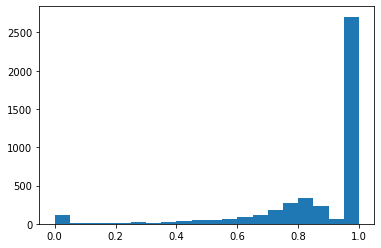

In [25]:
plt.hist(results_hist.res, bins=20);

In [26]:
len(pred_saver.worst_preds), len(pred_saver.best_preds)

(127, 1083)

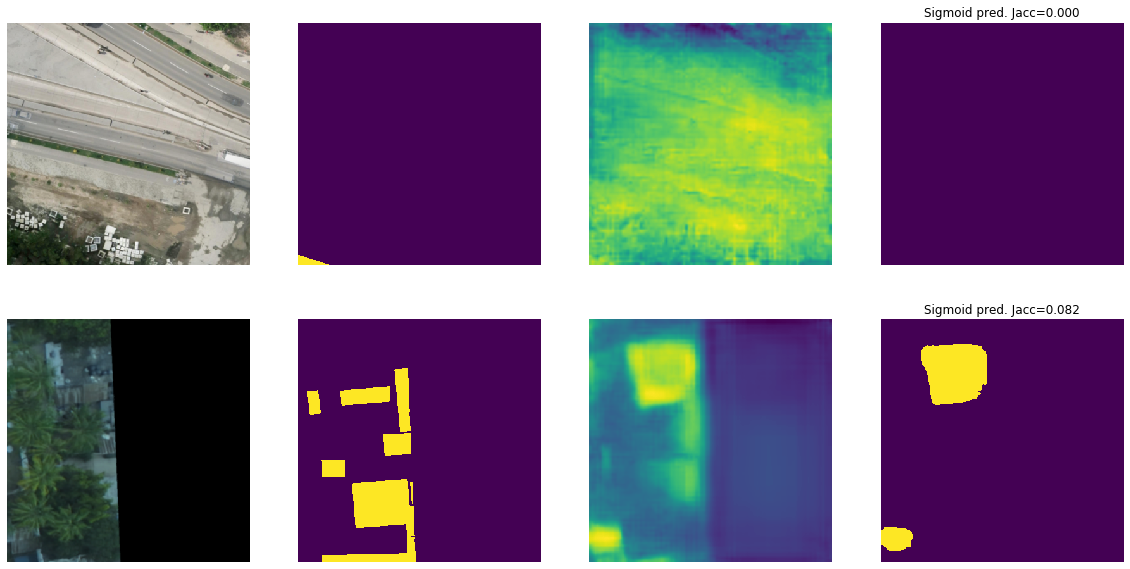

In [42]:
# Worst predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.worst_preds))
    img = pred_saver.worst_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.worst_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.worst_target[N])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.worst_preds[N]) > 0.5)
#     axes[i][3].imshow(pred_saver.worst_preds[N] > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.worst_metric[N]:.03f}")
    

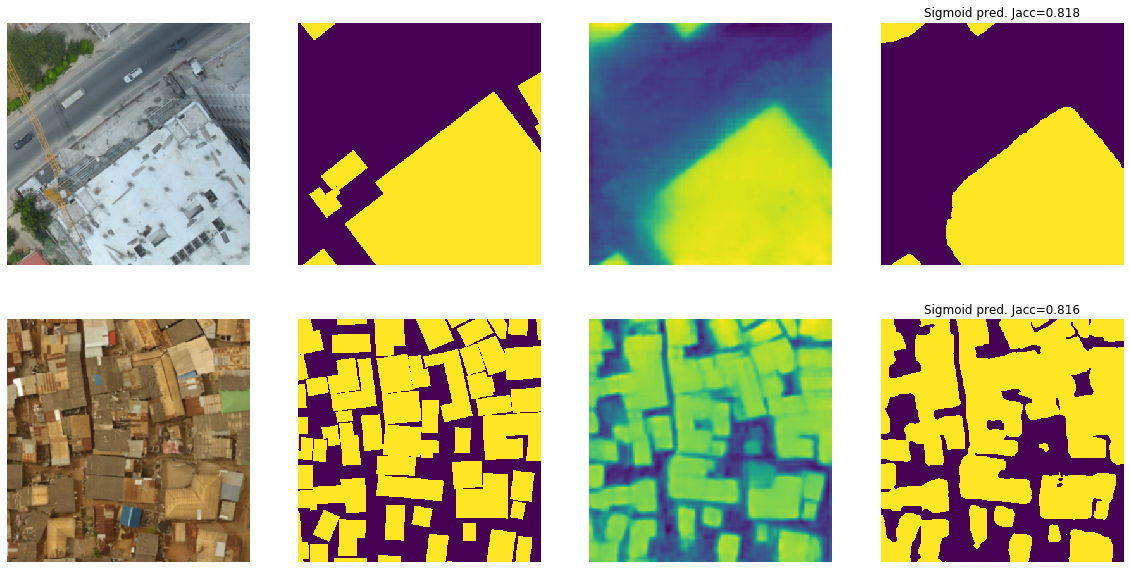

In [41]:
# Best predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.best_preds))
    img = pred_saver.best_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.best_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.best_target[N])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.best_preds[N]) > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.best_metric[N]:.03f}")
    

# Test CRF

In [200]:
import morphsnakes as ms

In [201]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [202]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_img)

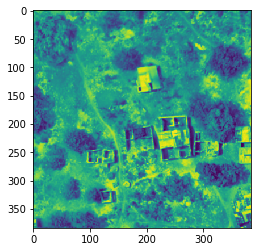

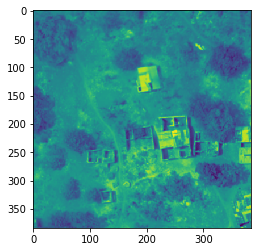

In [203]:
plt.imshow(cl1)
plt.show()
plt.imshow(gray_img)

In [204]:
gray_img.max()

252

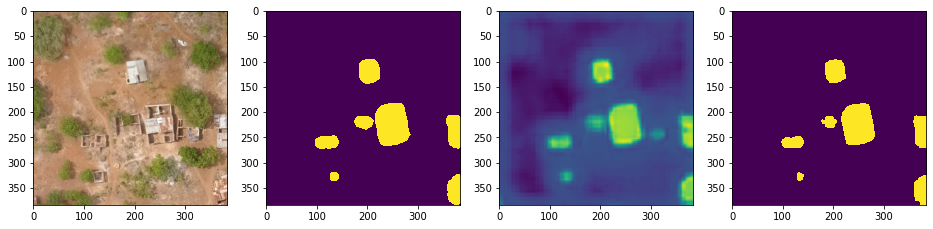

In [227]:
ac_pred = ms.morphological_chan_vese(pred, iterations=10, 
                                         init_level_set=pred,
#                                          init_level_set="checkerboard",
                                         smoothing=2, #threshold=0.31,
#                                          balloon=1
#                                          lambda1=0.5,
#                                          lambda2=2,
                                    )

fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
axes[0].imshow(img)
axes[1].imshow(ac_pred)
axes[2].imshow(pred)
axes[3].imshow(sigmoid(pred) > 0.5)

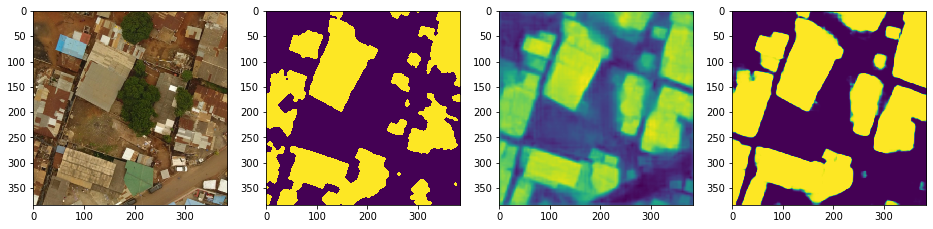

# Looking for bugs